# Process data from the IMU testing rig

The IMU testing rig was an arm that could swivel and move forward and back.  There was an IMU mounted on the end of the arm, and another on the base, and an encoder on the swivel.

Here, we test how well the IMU on the end can recover the angle of the arm from the encoder and how well it can match the forward-back acceleration measured by the IMU on the base.

![Testing Rig](/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/static_straight_up.jpg Testing)

### Setup

Import the various libraries that we need.

In [2]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_context('notebook', font_scale=1.0)

%matplotlib inline

And import the functions from the imucapture package.

In [3]:
from imucapture.data import Data
from imucapture.calib import Calib
from imucapture.transform import Transform, eul2rotm

## Load the data

### Calibration data

In [4]:
calibfilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/calib.hdf5'

In [5]:
calibdata = Data.from_file_smart(calibfilename)

ERROR:root:unknown dataset type: unknownassuming raw data


In the calibration data set, we have both IMUs, but we only have a real calibration for the first one.  The one on the base doesn't move, and so we can't get multiple axes.  So we'll just work with the first one.

In [6]:
calibdata1 = calibdata.get_one_imu(0)

calib = Calib()
calib.parse_data(calibdata1)

True

Check the basis matrix.

In [7]:
world_basis = calib.imu_bases[0]

world_basis

array([[ 0.04575447,  0.01030906, -0.99889952],
       [ 0.9988925 ,  0.01050683,  0.04586259],
       [ 0.01096806, -0.99989166, -0.00981691]])

Rows (CHECK) in the world basis represent the world's axes in IMU coordinates.  Here, the world's X axis (forward and back) is mostly along the chip's -Z axis.  The world's Y axis (side to side) is mostly the chip's X axis.  And the world's Z axis (up and down) is mostly the chip's Y axis.

This makes sense based on the picture of the rig.

### Rotation only data

In this data set, the arm only rotates back and forth.

In [8]:
datafilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_only.hdf5'

data = Data.from_file_smart(datafilename, resample=True)

ERROR:root:unknown dataset type: unknownassuming raw data


In [9]:
t = data.timestamps / 1000.0        # convert from milliseconds

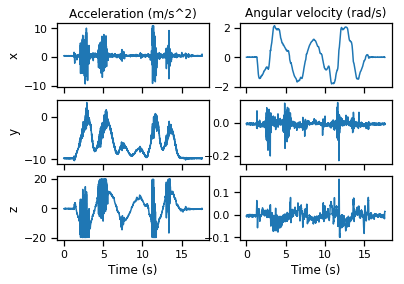

In [10]:
fig, ax = plt.subplots(3, 2, sharex=True)

for i, (acc1, gyro1, lab1) in enumerate(zip(data.get_acceleration(), data.get_gyroscope(), 
                                            ['x','y','z'])):
    ax[i, 0].plot(t, acc1)
    ax[i, 0].set_ylabel(lab1)
    
    ax[i, 1].plot(t, gyro1)

ax[0, 0].set_title('Acceleration (m/s^2)')
ax[0, 1].set_title('Angular velocity (rad/s)')

ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')

plt.show()

Raw acceleration and angular velocity data.

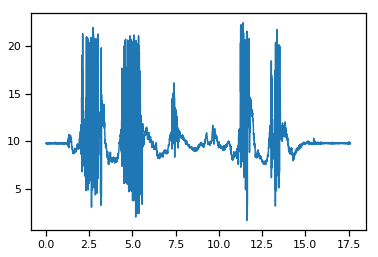

In [11]:
mag = np.linalg.norm(data.get_acceleration(), axis=0)

plt.plot(t, mag)

Process the data using the DSF and Madgwick algorithms

In [11]:
accdyn_dsf, orient_dsf = Transform().get_orientation_dsf(data, calib, imu=0, filter_num_samples=10, accdynmag=200.0)

(3, 3520)
(3, 3520)


In [12]:
accdyn_mad, orient_mad = Transform().get_orientation_madgwick(data, calib, imu=0, filter_num_samples=10,
                                                              beta=np.deg2rad(2.86))

Get the true orientation from the encoder

In [13]:
with h5py.File(datafilename) as h5file:
    orient_z0 = np.deg2rad(np.array(h5file['/data/Encoder']))
    t_enc = np.array(h5file['/data/time'])

orient_z0 = orient_z0 - orient_z0[0]

# interpolate onto the same timebase as the IMU data
orient_z = np.interp(data.timestamps, t_enc, orient_z0)

# filter with a running average
orient_z = np.convolve(orient_z, np.ones((80,))/80, mode='same')

orient_true = np.zeros_like(orient_dsf)
orient_true[2, :] = orient_z

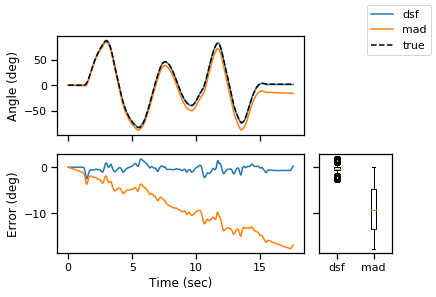

In [14]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1], sharex=ax1)
ax3 = fig.add_subplot(gs[1, -1], sharey=ax2)

ax1.plot(t, np.rad2deg(orient_dsf[2, :]), label='dsf')
ax1.plot(t, np.rad2deg(orient_mad[2, :]), label='mad')
ax1.plot(t, np.rad2deg(orient_true[2, :]), 'k--', label='true')

ax1.set_ylabel('Angle (deg)')
fig.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

err = np.array([np.rad2deg(orient_dsf[2, :] - orient_true[2, :]), np.rad2deg(orient_mad[2, :] - orient_true[2, :])])
ax2.plot(t, err[0, :], label='dsf')
ax2.plot(t, err[1, :], label='mad')

ax2.set_ylabel('Error (deg)')
ax2.set_xlabel('Time (sec)')

ax3.boxplot(err.T)
ax3.set_xticklabels(['dsf', 'mad'])
plt.setp(ax3.get_yticklabels(), visible=False)

plt.show()

## Rotation and translation

In [15]:
datafilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_and_translate.hdf5'

data = Data.from_file_smart(datafilename, resample=True)

ERROR:root:unknown dataset type: unknownassuming raw data


In [17]:
t = data.timestamps / 1000.0        # convert from milliseconds

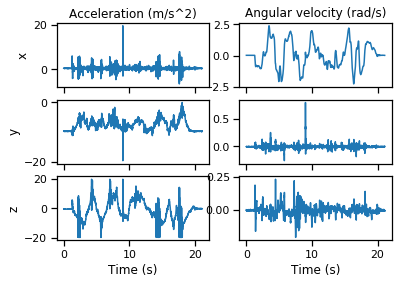

In [18]:
fig, ax = plt.subplots(3, 2, sharex=True)

for i, (acc1, gyro1, lab1) in enumerate(zip(data.get_acceleration(), data.get_gyroscope(), 
                                            ['x','y','z'])):
    ax[i, 0].plot(t, acc1)
    ax[i, 0].set_ylabel(lab1)
    
    ax[i, 1].plot(t, gyro1)

ax[0, 0].set_title('Acceleration (m/s^2)')
ax[0, 1].set_title('Angular velocity (rad/s)')

ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')

plt.show()

In [19]:
accdyn_dsf, orient_dsf = Transform().get_orientation_dsf(data, calib, imu=0, filter_num_samples=10, accdynmag=200.0)
accdyn_mad, orient_mad = Transform().get_orientation_madgwick(data, calib, imu=0, filter_num_samples=10,
                                                              beta=np.deg2rad(2.86))

(3, 4219)
(3, 4219)


In [20]:
with h5py.File(datafilename) as h5file:
    orient_z0 = np.deg2rad(np.array(h5file['/data/Encoder']))
    t_enc = np.array(h5file['/data/time'])

orient_z0 = orient_z0 - orient_z0[0]

# interpolate onto the same timebase as the IMU data
orient_z = np.interp(data.timestamps, t_enc, orient_z0)

# filter with a running average
orient_z = np.convolve(orient_z, np.ones((80,))/80, mode='same')

orient_true = np.zeros_like(orient_dsf)
orient_true[2, :] = orient_z

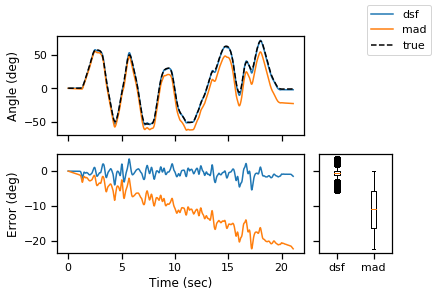

In [21]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1], sharex=ax1)
ax3 = fig.add_subplot(gs[1, -1], sharey=ax2)

ax1.plot(t, np.rad2deg(orient_dsf[2, :]), label='dsf')
ax1.plot(t, np.rad2deg(orient_mad[2, :]), label='mad')
ax1.plot(t, np.rad2deg(orient_true[2, :]), 'k--', label='true')

ax1.set_ylabel('Angle (deg)')
fig.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

err = np.array([np.rad2deg(orient_dsf[2, :] - orient_true[2, :]), np.rad2deg(orient_mad[2, :] - orient_true[2, :])])
ax2.plot(t, err[0, :], label='dsf')
ax2.plot(t, err[1, :], label='mad')

ax2.set_ylabel('Error (deg)')
ax2.set_xlabel('Time (sec)')

ax3.boxplot(err.T)
ax3.set_xticklabels(['dsf', 'mad'])
plt.setp(ax3.get_yticklabels(), visible=False)

plt.show()

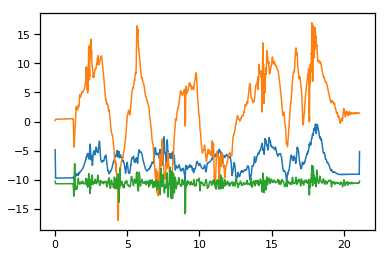

In [23]:
plt.plot(t, accdyn_mad.T)

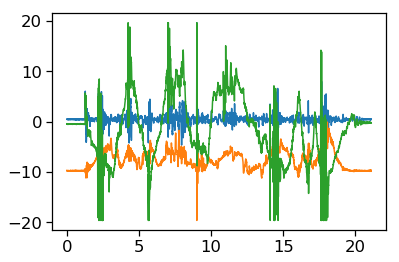

In [68]:
plt.plot(t, data.get_acceleration(0).T)